# About

These is a base solution of PID.

In [10]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier

# Read data

In [11]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

In [12]:
data_path = "/notebooks/data/samples_for_comparison"
data_train = pandas.read_csv(data_path + "/sample_train.csv")
data_test = pandas.read_csv(data_path + "/sample_test.csv")

# Train TMVA

In [13]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

def train_classifiers(data_train, features, pdg):
    
    labels = (numpy.abs(data_train.MCParticleType.values) == pdg) * 1.

    tmva_mlp = TMVAClassifier(method='kMLP',
                          features=features,
                          factory_options="V:!Silent:!Color:!DrawProgressBar",
                          H='true',
                          V='true',
                          EpochMonitoring='true',
                          HiddenLayers=int(1.2*len(features)),
                          UseRegulator='true',
                          ConvergenceImprove = "1e-16",
                          ConvergenceTests = "15",
                          VarTransform = "Norm",
                          NCycles = 50,
                          NeuronType = "sigmoid",
                          TrainingMethod = "BP",
                          EstimatorType = "CE")

    tmva_bdt = TMVAClassifier(method='kBDT',
                          features=features,
                          factory_options="V:!Silent:!Color:!DrawProgressBar",
                          H='false',
                          V='true',
                          NTrees=50,
                          VarTransform = "Norm",
                          BoostType = "AdaBoost",
                          PruneMethod = "CostComplexity",
                          PruneStrength = -1,
                          MaxDepth = 3,
                          PruningValFraction = 0.3)
    
    tmva_mlp.fit(data_train, labels)
    tmva_bdt.fit(data_train, labels)
    
    return (tmva_mlp, tmva_bdt)

In [ ]:
tmva_clf_all = {}
features_all = {}

for one_particle in particles:
    
    netconfig_path = "/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all[one_particle] = get_features(netconfig_path)
    
    pdg = particle_pdg_codes[one_particle]
    tmva_clf_all[one_particle] = train_classifiers(data_train, features_all[one_particle], pdg)

# Features

In [39]:
for key in features_all.keys():
    print key
    print features_all[key], '\n'

Ghost
['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe'] 

Muon
['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 'MuonBkgLL', 'MuonMuLL', 'MuonNShared', 'InAccEcal', 'EcalPIDe', 'EcalPIDmu', 'InAccHcal', 'HcalPIDe', 'HcalPIDmu', 'InAccPrs', 'PrsPIDe', 'InAccBrem', 'BremPIDe'] 

Pion
['TrackP', 'TrackPt'

# Test TMVA MLP

In [ ]:
probas_all = {}
labels_all = {}

for one_particle in particles:
    
    pdg = particle_pdg_codes[one_particle]
    labels = (numpy.abs(data_test.MCParticleType.values) == pdg) * 1.
    labels_all[one_particle] = (labels, labels)
    
    
    proba_mlp = tmva_clf_all[one_particle][0].predict_proba(data_test)
    proba_bdt = tmva_clf_all[one_particle][1].predict_proba(data_test)
    probas_all[one_particle] = (proba_mlp, proba_bdt)

In [36]:
for key in probas_all.keys():
    print key
    print 'MLP probas:'
    print probas_all[key][0][:10,:]

Ghost
MLP probas:
[[ 0.43822611  0.56177389]
 [ 0.44613152  0.55386848]
 [ 0.3611995   0.6388005 ]
 [ 0.49565296  0.50434704]
 [ 0.30297177  0.69702823]
 [ 0.4883218   0.5116782 ]
 [ 0.49531155  0.50468845]
 [ 0.16762502  0.83237498]
 [ 0.21857934  0.78142066]
 [ 0.48264937  0.51735063]]
Muon
MLP probas:
[[ 0.45471478  0.54528522]
 [ 0.36916302  0.63083698]
 [ 0.44995854  0.55004146]
 [ 0.46182652  0.53817348]
 [ 0.21202588  0.78797412]
 [ 0.25334091  0.74665909]
 [ 0.4799131   0.5200869 ]
 [ 0.15957785  0.84042215]
 [ 0.38942083  0.61057917]
 [ 0.49870233  0.50129767]]
Pion
MLP probas:
[[ 0.18231598  0.81768402]
 [ 0.16150767  0.83849233]
 [ 0.00699304  0.99300696]
 [ 0.00673039  0.99326961]
 [ 0.34944924  0.65055076]
 [ 0.0547273   0.9452727 ]
 [ 0.01013389  0.98986611]
 [ 0.35015658  0.64984342]
 [ 0.26931037  0.73068963]
 [ 0.2298468   0.7701532 ]]
Kaon
MLP probas:
[[ 0.34013356  0.65986644]
 [ 0.33622057  0.66377943]
 [ 0.49975811  0.50024189]
 [ 0.49833007  0.50166993]
 [ 0.40033

In [24]:
def get_roc_curves(probas_all, labels_all, particles, colors, clf='MLP'):
    
    if clf == 'MLP':
        clf_ind = 0
    elif clf == 'BDT':
        clf_ind = 1

    plt.figure(figsize=(10,7))

    for one_particle, one_color in zip(particles, colors):

        labels = labels_all[one_particle][clf_ind]
        probas = probas_all[one_particle][clf_ind][:, 1]
        roc_auc = roc_auc_score(labels, probas)
        fpr, tpr, _ = roc_curve(labels, probas)
        plt.plot(fpr, tpr, label=one_particle + ', %.2f' % roc_auc, color=one_color, linewidth=2)

    plt.title("ROC AUC", size=15)
    plt.xlabel("FPR", size=15)
    plt.ylabel("TPR", size=15)
    plt.legend(loc='best',prop={'size':15})
    plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.show()

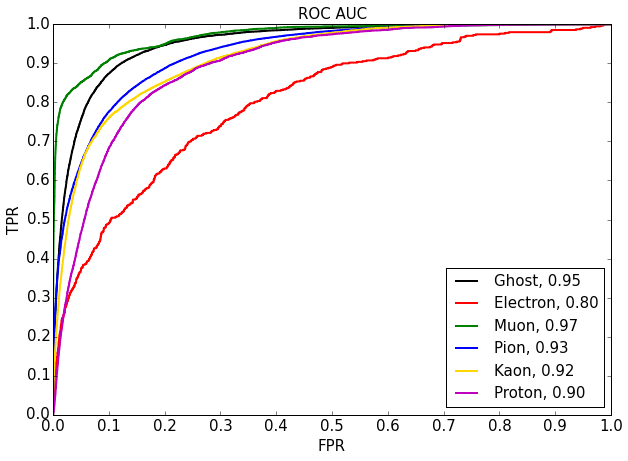

In [25]:
get_roc_curves(probas_all, labels_all, particles, colors, clf='MLP')

# Test TMVA BDT

In [37]:
for key in probas_all.keys():
    print key
    print 'BDT probas:'
    print probas_all[key][1][:10,:]

Ghost
BDT probas:
[[ 0.70479058  0.29520942]
 [ 0.65433362  0.34566638]
 [ 0.47004925  0.52995075]
 [ 0.85255483  0.14744517]
 [ 0.41375226  0.58624774]
 [ 0.85369166  0.14630834]
 [ 0.90943336  0.09056664]
 [ 0.44574277  0.55425723]
 [ 0.33360151  0.66639849]
 [ 0.7881202   0.2118798 ]]
Muon
BDT probas:
[[ 0.73217153  0.26782847]
 [ 0.50854037  0.49145963]
 [ 0.75608761  0.24391239]
 [ 0.8045901   0.1954099 ]
 [ 0.40840454  0.59159546]
 [ 0.50222537  0.49777463]
 [ 0.84972035  0.15027965]
 [ 0.39611038  0.60388962]
 [ 0.46431126  0.53568874]
 [ 0.58471837  0.41528163]]
Pion
BDT probas:
[[ 0.44392098  0.55607902]
 [ 0.36614643  0.63385357]
 [ 0.30371604  0.69628396]
 [ 0.13584493  0.86415507]
 [ 0.46716477  0.53283523]
 [ 0.35294915  0.64705085]
 [ 0.08233337  0.91766663]
 [ 0.48939356  0.51060644]
 [ 0.66669029  0.33330971]
 [ 0.35340784  0.64659216]]
Kaon
BDT probas:
[[ 0.53069571  0.46930429]
 [ 0.60513134  0.39486866]
 [ 0.90374071  0.09625929]
 [ 0.87007599  0.12992401]
 [ 0.64400

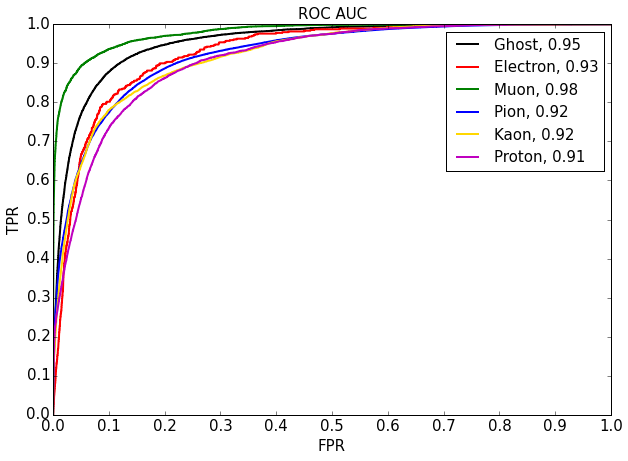

In [26]:
get_roc_curves(probas_all, labels_all, particles, colors, clf='BDT')